# 04 - Question answering using Retrieval Augmented Generation
In this notebook we will be using the output of the `document_processing.ipynb` notebook to answer questions using retrieval augmented generation.

Notebook overview:
1. Load the PDFs as plaintext (output of `document_processing.ipynb`).
2. Chunk the plaintext into a reasonable size, such that the LLMs context window can fit multiple chunks.
3. Embed each of the chunks using an LLM and store the embeddings in a vector store.
4. Answer a user question using the embeddings.

### Setup

In [1]:
import botocore
import boto3
from botocore.config import Config

In [2]:
boto3.__version__, botocore.__version__

('1.28.64', '1.31.64')

In [3]:
ssm_client = boto3.client("ssm")

In [4]:
bedrock_region_parameter = "/AgenticLLMAssistant/bedrock_region"
bedrock_endpoint_parameter = "/AgenticLLMAssistant/bedrock_endpoint"
s3_bucket_name_parameter = "/AgenticLLMAssistant/AgentDataBucketParameter"

BEDROCK_REGION = ssm_client.get_parameter(Name=bedrock_region_parameter)
BEDROCK_REGION = BEDROCK_REGION["Parameter"]["Value"]

S3_BUCKET_NAME = ssm_client.get_parameter(Name=s3_bucket_name_parameter)
S3_BUCKET_NAME = S3_BUCKET_NAME["Parameter"]["Value"]

BEDROCK_REGION, S3_BUCKET_NAME

('us-east-1', 'assistantbackendstack-agentdatabucket67afdfb9-pqa1faq3bool')

In [5]:
LLM_MODEL_ID = "anthropic.claude-v1"
LLM_MODEL_ID = "anthropic.claude-3-haiku-20240307-v1:0"
LLM_MODEL_ID = "anthropic.claude-v2"

In [6]:
retry_config = Config(
    region_name=BEDROCK_REGION, retries={"max_attempts": 10, "mode": "standard"}
)
bedrock_runtime = boto3.client("bedrock-runtime", config=retry_config)

Uncomment the call to `list_foundation_models()` below to see a list of all available models in the `BEDROCK_REGION`.

In [7]:
bedrock_client = boto3.client("bedrock", config=retry_config)
# bedrock_client.list_foundation_models()

### Load the PDFs as plaintext

In [8]:
from utils.helpers import load_list_from_s3

In [9]:
documents_processed = load_list_from_s3(S3_BUCKET_NAME, "documents_processed.json")

In [10]:
len(documents_processed)

2

We will be using Langchains vectorstores to store the embeddings, therefore, we will convert the documents to Langchain Document objects.

In [11]:
import json
from langchain.schema.document import Document

langchain_documents_text = []
langchain_documents_tables = []

for document in documents_processed:
    document_name = document["name"]
    document_source_location = document["source_location"]
    document_s3_metadata = document["metadata"]
    print(document_s3_metadata)
    mapping_to_original_page_numbers = {
        idx: pg_num
        for idx, pg_num in enumerate(json.loads(document_s3_metadata["pages_kept"]))
    }
    # remove pages_kept since we already put the original page number.
    del document_s3_metadata["pages_kept"]

    for page in document["pages"]:
        # Turn each page into a Langchain Document.
        # Note: you could choose to also prepend part of the previous document
        # and append part of the next document to include more context for documents
        # that have many pages which continue their text on the next page.
        current_metadata = {
            "document_name": document_name,
            "document_source_location": document_source_location,
            "page_number": page["page"],
            "original_page_number": mapping_to_original_page_numbers[page["page"]],
        }
        # merge the document_s3_metadata into the langchain Document metadata
        # to be able to use them for filtering.
        current_metadata.update(document_s3_metadata)

        langchain_documents_text.append(
            Document(page_content=page["page_text"], metadata=current_metadata)
        )

        # Turn all the tables of the pages into seperate Langchain Documents as well
        for table_markdown in page["page_tables"]:
            langchain_documents_tables.append(
                Document(page_content=table_markdown, metadata=current_metadata)
            )

{'company': 'Amazon', 'year': '2022', 'pages_kept': '[15, 17, 18, 47, 48]', 'doc_url': 'https://s2.q4cdn.com/299287126/files/doc_financials/2023/ar/Amazon-2022-Annual-Report.pdf'}
{'company': 'Amazon', 'year': '2021', 'pages_kept': '[14, 16, 17, 18, 46, 47]', 'doc_url': 'https://s2.q4cdn.com/299287126/files/doc_financials/2022/ar/Amazon-2021-Annual-Report.pdf'}


In [12]:
print(
    f"Your documents contain {len(langchain_documents_text)}"
    f" pages and {len(langchain_documents_tables)} tables combined"
)

Your documents contain 11 pages and 5 tables combined


In [13]:
len(langchain_documents_text), len(langchain_documents_tables)

(11, 5)

In [14]:
chunk_lengths = [len(doc.page_content) for doc in langchain_documents_text]

print(
    f"Number of chunks: {len(chunk_lengths)},"
    f" Max chunk length {max(chunk_lengths)},"
    f" Min chunk length: {min(chunk_lengths)}"
)

Number of chunks: 11, Max chunk length 5846, Min chunk length: 1241


Plot the distribution of the length of the smaller chunks, to determine if some of them should be removed

In [15]:
import matplotlib.pyplot as plt
import seaborn as sns


def plot_chunks_length_distribution(chunks, bin_size=50):
    chunk_lengths = [len(doc.page_content) for doc in chunks]
    bin_size = 50
    num_bins = (max(chunk_lengths) - min(chunk_lengths)) // bin_size + 1

    # Display smoothed histogram using seaborn
    sns.histplot(chunk_lengths, kde=True, bins=num_bins, edgecolor="black")
    plt.xlabel("Chunk Length")
    plt.ylabel("Frequency")
    plt.title("Distribution of Chunk Lengths")
    plt.show()

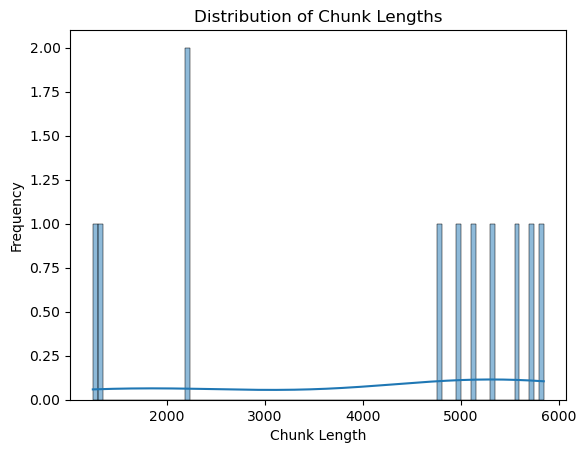

In [16]:
plot_chunks_length_distribution(langchain_documents_text, bin_size=50)

### Chunk the Documents containing page text and tables

In [17]:
%pip install tiktoken --quiet

Note: you may need to restart the kernel to use updated packages.


In [18]:
from langchain.text_splitter import TokenTextSplitter

# The chunk overlap duplicates some text across chunks to prevent context from being lost between chunks.
# TODO: the following spliting uses tiktoken, create a custom one that use the tokenizer from anthropic.
text_splitter = TokenTextSplitter(chunk_size=512, chunk_overlap=64)

In [19]:
langchain_documents_text_chunked = text_splitter.split_documents(
    langchain_documents_text + langchain_documents_tables
)

In [20]:
len(langchain_documents_text_chunked)

65

Due to splitting of the chunks, we may have created some small chunks that are already captured in the chunk overlap.<br>
It is recommended to have a look and estimate until which chunk length, the chunks can be removed.<br>
The reason for this is that semantic search can occasionally favor chunks containing very little content.

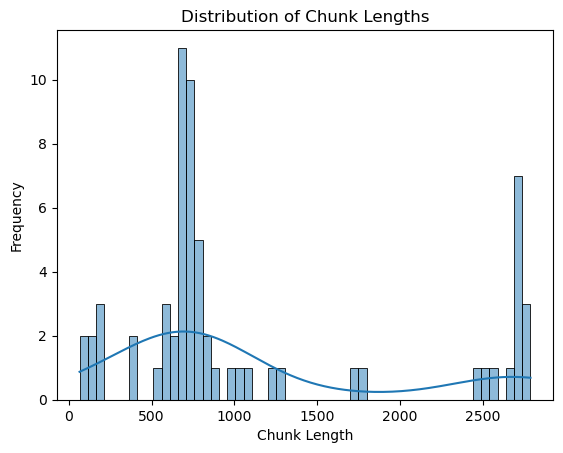

In [21]:
plot_chunks_length_distribution(langchain_documents_text_chunked, bin_size=50)

### Embed the documents and store them in a vector store

For the embedding model we use Amazon Titan embedding model available through Amazon Bedrock.
There are other embeddings models you can use depending on the use. Run the following cell to see all the available embedding models.

In [22]:
[x for x in bedrock_client.list_foundation_models()["modelSummaries"] if "EMBEDDING" in x["outputModalities"]]

[{'modelArn': 'arn:aws:bedrock:us-east-1::foundation-model/amazon.titan-embed-g1-text-02',
  'modelId': 'amazon.titan-embed-g1-text-02',
  'modelName': 'Titan Text Embeddings v2',
  'providerName': 'Amazon',
  'inputModalities': ['TEXT'],
  'outputModalities': ['EMBEDDING'],
  'customizationsSupported': [],
  'inferenceTypesSupported': ['ON_DEMAND']},
 {'modelArn': 'arn:aws:bedrock:us-east-1::foundation-model/amazon.titan-embed-text-v1:2:8k',
  'modelId': 'amazon.titan-embed-text-v1:2:8k',
  'modelName': 'Titan Embeddings G1 - Text',
  'providerName': 'Amazon',
  'inputModalities': ['TEXT'],
  'outputModalities': ['EMBEDDING'],
  'responseStreamingSupported': False,
  'customizationsSupported': [],
  'inferenceTypesSupported': ['PROVISIONED']},
 {'modelArn': 'arn:aws:bedrock:us-east-1::foundation-model/amazon.titan-embed-text-v1',
  'modelId': 'amazon.titan-embed-text-v1',
  'modelName': 'Titan Embeddings G1 - Text',
  'providerName': 'Amazon',
  'inputModalities': ['TEXT'],
  'outputM

Run the following cell to setup the connection to the embedding model of choice.

In [23]:
from langchain.embeddings import BedrockEmbeddings
from langchain.llms.bedrock import Bedrock as LangchainBedrock

# Define an embedding model to generate embeddings
embedding_model_id = "amazon.titan-embed-text-v1"
embedding_model = BedrockEmbeddings(model_id=embedding_model_id, client=bedrock_runtime)

<div class="alert alert-block alert-warning">
Warning: The following lines of code create embedding for each document chunk and store them, this will use your embedding model for each document and incur costs.
</div>

In [24]:
len(langchain_documents_text_chunked)

65

You may see a "An error occurred (ResourceNotFoundException) when calling the InvokeModel operation: Could not resolve the foundation model from the provided model identifier." error when trying to run the following cell. If this happens then you should visit the "Bedrock" service in your AWS account and request for access to the models in the "Model access" section

In [25]:
%%time
from langchain.vectorstores import FAISS

faiss = FAISS.from_documents(langchain_documents_text_chunked, embedding_model)

CPU times: user 210 ms, sys: 20 ms, total: 230 ms
Wall time: 21.3 s


In [26]:
faiss.save_local("faiss_vector_store")

### Answer questions using RAG

In [27]:
from langchain.chains import ConversationChain, LLMChain
from langchain.memory import ConversationBufferMemory
from langchain.prompts.prompt import PromptTemplate

# Define a custom template for structured data extraction
template = """\n\nHuman:
The following is a friendly conversation between a human and an AI assistant.
The assistant is helpful and answers questions about documents based on extracts of those documents available within the <context></context> XML tags.
When answering, the assistant abides by the rules defined in the <rules></rules> XML tags.

The rules are below:
<rules>
The assistant answers the human questions accurately and concisely.
When answering, the assistant relies on the context available in the <context></context> XML tags below.
The assistant considers the conversation history available in the <history></history> XML tags when answering.
If the assistant does not know the answer to a question, it truthfully says it does not know.
The assistant answers in Markdown and puts the answer inside <response></response> XML tags.
</rules>

The retrieved document chuncks that the AI assistant uses to respond are below within the <context></context> XML tags, each document chunk is within a <document></document> XML tags:
<context>
{context}
</context>

Current conversation:
<history>
{history}
</history>

The user input to respond to is within the input XML tags below:
<input>
{input}
</input>
\n\nAssistant: """

PROMPT = PromptTemplate(
    input_variables=["history", "input", "context"], template=template
)

claude_llm = LangchainBedrock(
    model_id=LLM_MODEL_ID,
    client=bedrock_runtime,
    model_kwargs={"max_tokens_to_sample": 512, "temperature": 0.0},
)

conversation = LLMChain(
    llm=claude_llm,
    memory=ConversationBufferMemory(input_key="input"),
    prompt=PROMPT,
    verbose=True,
)

In [28]:
def combine_documents(retrieved_documents):
    combined_documents = ""
    # Add each of the extracts to the query
    for idx, extract in enumerate(retrieved_documents):
        combined_documents += f"<document>{extract.page_content}</document>\n"

    return combined_documents

In [29]:
%%time
query = "Who were in the board of directors of Amazon in 2021 and what were their roles?"

k = 4
retrieved_chuncks = faiss.similarity_search(query=query, k=k)

CPU times: user 2.14 ms, sys: 3.83 ms, total: 5.98 ms
Wall time: 430 ms


In [ ]:
%%time
response = conversation.predict(
    input=query, context=combine_documents(retrieved_chuncks)
)

In [31]:
response = response.strip().strip("<response>").strip("</response>").strip()

In [32]:
from IPython.display import display, Markdown

display(Markdown(response))

Based on the documents provided in the context, the Amazon board of directors in 2021 included:

- Jeffrey P. Bezos - Executive Chair
- Andrew R. Jassy - President and Chief Executive Officer  
- Keith B. Alexander - CEO, President, and Chair of IronNet, Inc.
- Edith W. Cooper - Former Executive Vice President, Goldman Sachs Group, Inc.   
- Jamie S. Gorelick - Partner, Wilmer Cutler Pickering Hale and Dorr LLP
- Daniel P. Huttenlocher - Dean, MIT Schwarzman College of Computing
- Judith A. McGrath - Former Chair and CEO, MTV Networks

## Upload semantic search index to S3

In [ ]:
!aws s3 sync ./faiss_vector_store s3://{S3_BUCKET_NAME}/semantic_search_index/faiss_vector_store/